In [3]:

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


In [226]:
data_full=pd.read_csv("../raw_data/trainset_full.csv")
data_miss=pd.read_csv("../raw_data/trainset.csv")

In [3]:
data_miss

,index,turbine_id,measured_at,wind_speed,power,nacelle_direction,wind_direction,rotor_speed,generator_speed,temp_environment,temp_hydraulic_oil,temp_gear_bearing,cosphi,blade_angle_avg,hydraulic_pressure,park_id,error_category
0,0,11,2020-01-01 00:00:00+00:00,0.433333,0.121250,266.0,266.3,0.677852,0.569444,5.0,20.0,32.0,0.85,-1.9,189.2,1,NO_ERROR
1,1,11,2020-01-01 00:10:00+00:00,0.458333,0.138750,266.6,267.0,0.704698,0.591766,5.0,20.0,33.0,0.88,NaN,189.5,1,NO_ERROR
2,2,11,2020-01-01 00:20:00+00:00,0.508333,0.182950,270.7,269.4,0.771812,0.647321,5.0,20.0,34.0,0.92,-2.0,190.1,1,NO_ERROR
3,3,11,2020-01-01 00:30:00+00:00,0.525000,0.218100,272.1,272.7,0.805369,0.676091,5.0,20.0,38.0,0.94,-2.0,190.0,1,NO_ERROR
4,4,11,2020-01-01 00:40:00+00:00,0.541667,0.234300,279.5,281.1,0.832215,0.700397,5.0,20.0,41.0,0.95,-2.0,189.9,1,NO_ERROR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367185,1367185,29,2021-04-30 22:10:00+00:00,0.253846,0.004242,64.9,65.9,0.525000,0.468333,12.0,42.0,53.0,0.60,-1.7,247.2,2,NO_ERROR
1367186,1367186,29,2021-04-30 22:20:00+00:00,0.261538,0.007152,64.9,68.5,0.525000,0.466733,11.0,42.0,53.0,0.90,-1.8,246.8,2,NO_ERROR
1367187,1367187,29,2021-04-30 22:30:00+00:00,0.261538,0.007970,64.9,65.2,0.525000,0.466733,11.0,43.0,54.0,0.90,-1.7,247.0,2,NO_ERROR
1367188,1367188,29,2021-04-30 22:40:00+00:00,0.307692,0.030394,64.9,62.1,0.525000,0.468933,11.0,43.0,55.0,1.00,-2.5,246.9,2,NO_ERROR


Missing data given as NaN

Missing values are only present for wind_speed, power, rotor_speed, generator_speed, temp_environment, temp_hydraulic_oil, temp_gear_bearing, blade_angle_avg

In [13]:
n_miss = np.sum(np.asarray(data_miss.isna()), axis=0)
keys_miss = data_miss.keys()
comb = list(zip(keys_miss, n_miss))
print(comb)

[('index', 0), ('turbine_id', 0), ('measured_at', 0), ('wind_speed', 101176), ('power', 58136), ('nacelle_direction', 0), ('wind_direction', 0), ('rotor_speed', 96922), ('generator_speed', 98536), ('temp_environment', 71404), ('temp_hydraulic_oil', 71558), ('temp_gear_bearing', 70575), ('cosphi', 0), ('blade_angle_avg', 187489), ('hydraulic_pressure', 0), ('park_id', 0), ('error_category', 0)]


(array([4.26325e+05, 9.55850e+04, 3.11390e+04, 1.07220e+04, 9.20000e+01,
        7.00000e+00]),
 array([0.5       , 1.66666667, 2.83333333, 4.        , 5.16666667,
        6.33333333, 7.5       ]),
 <BarContainer object of 6 artists>)

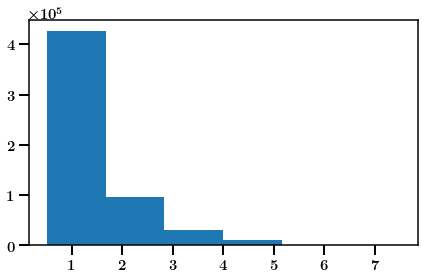

In [3]:
import matplotlib.pyplot as plt
plt.hist(np.sum(np.asarray(data_miss.isna()), axis=1), bins=np.linspace(0.5, 7.5, 7))

how many are missing in a row

there is a lot of data missing typically and a lot in a row


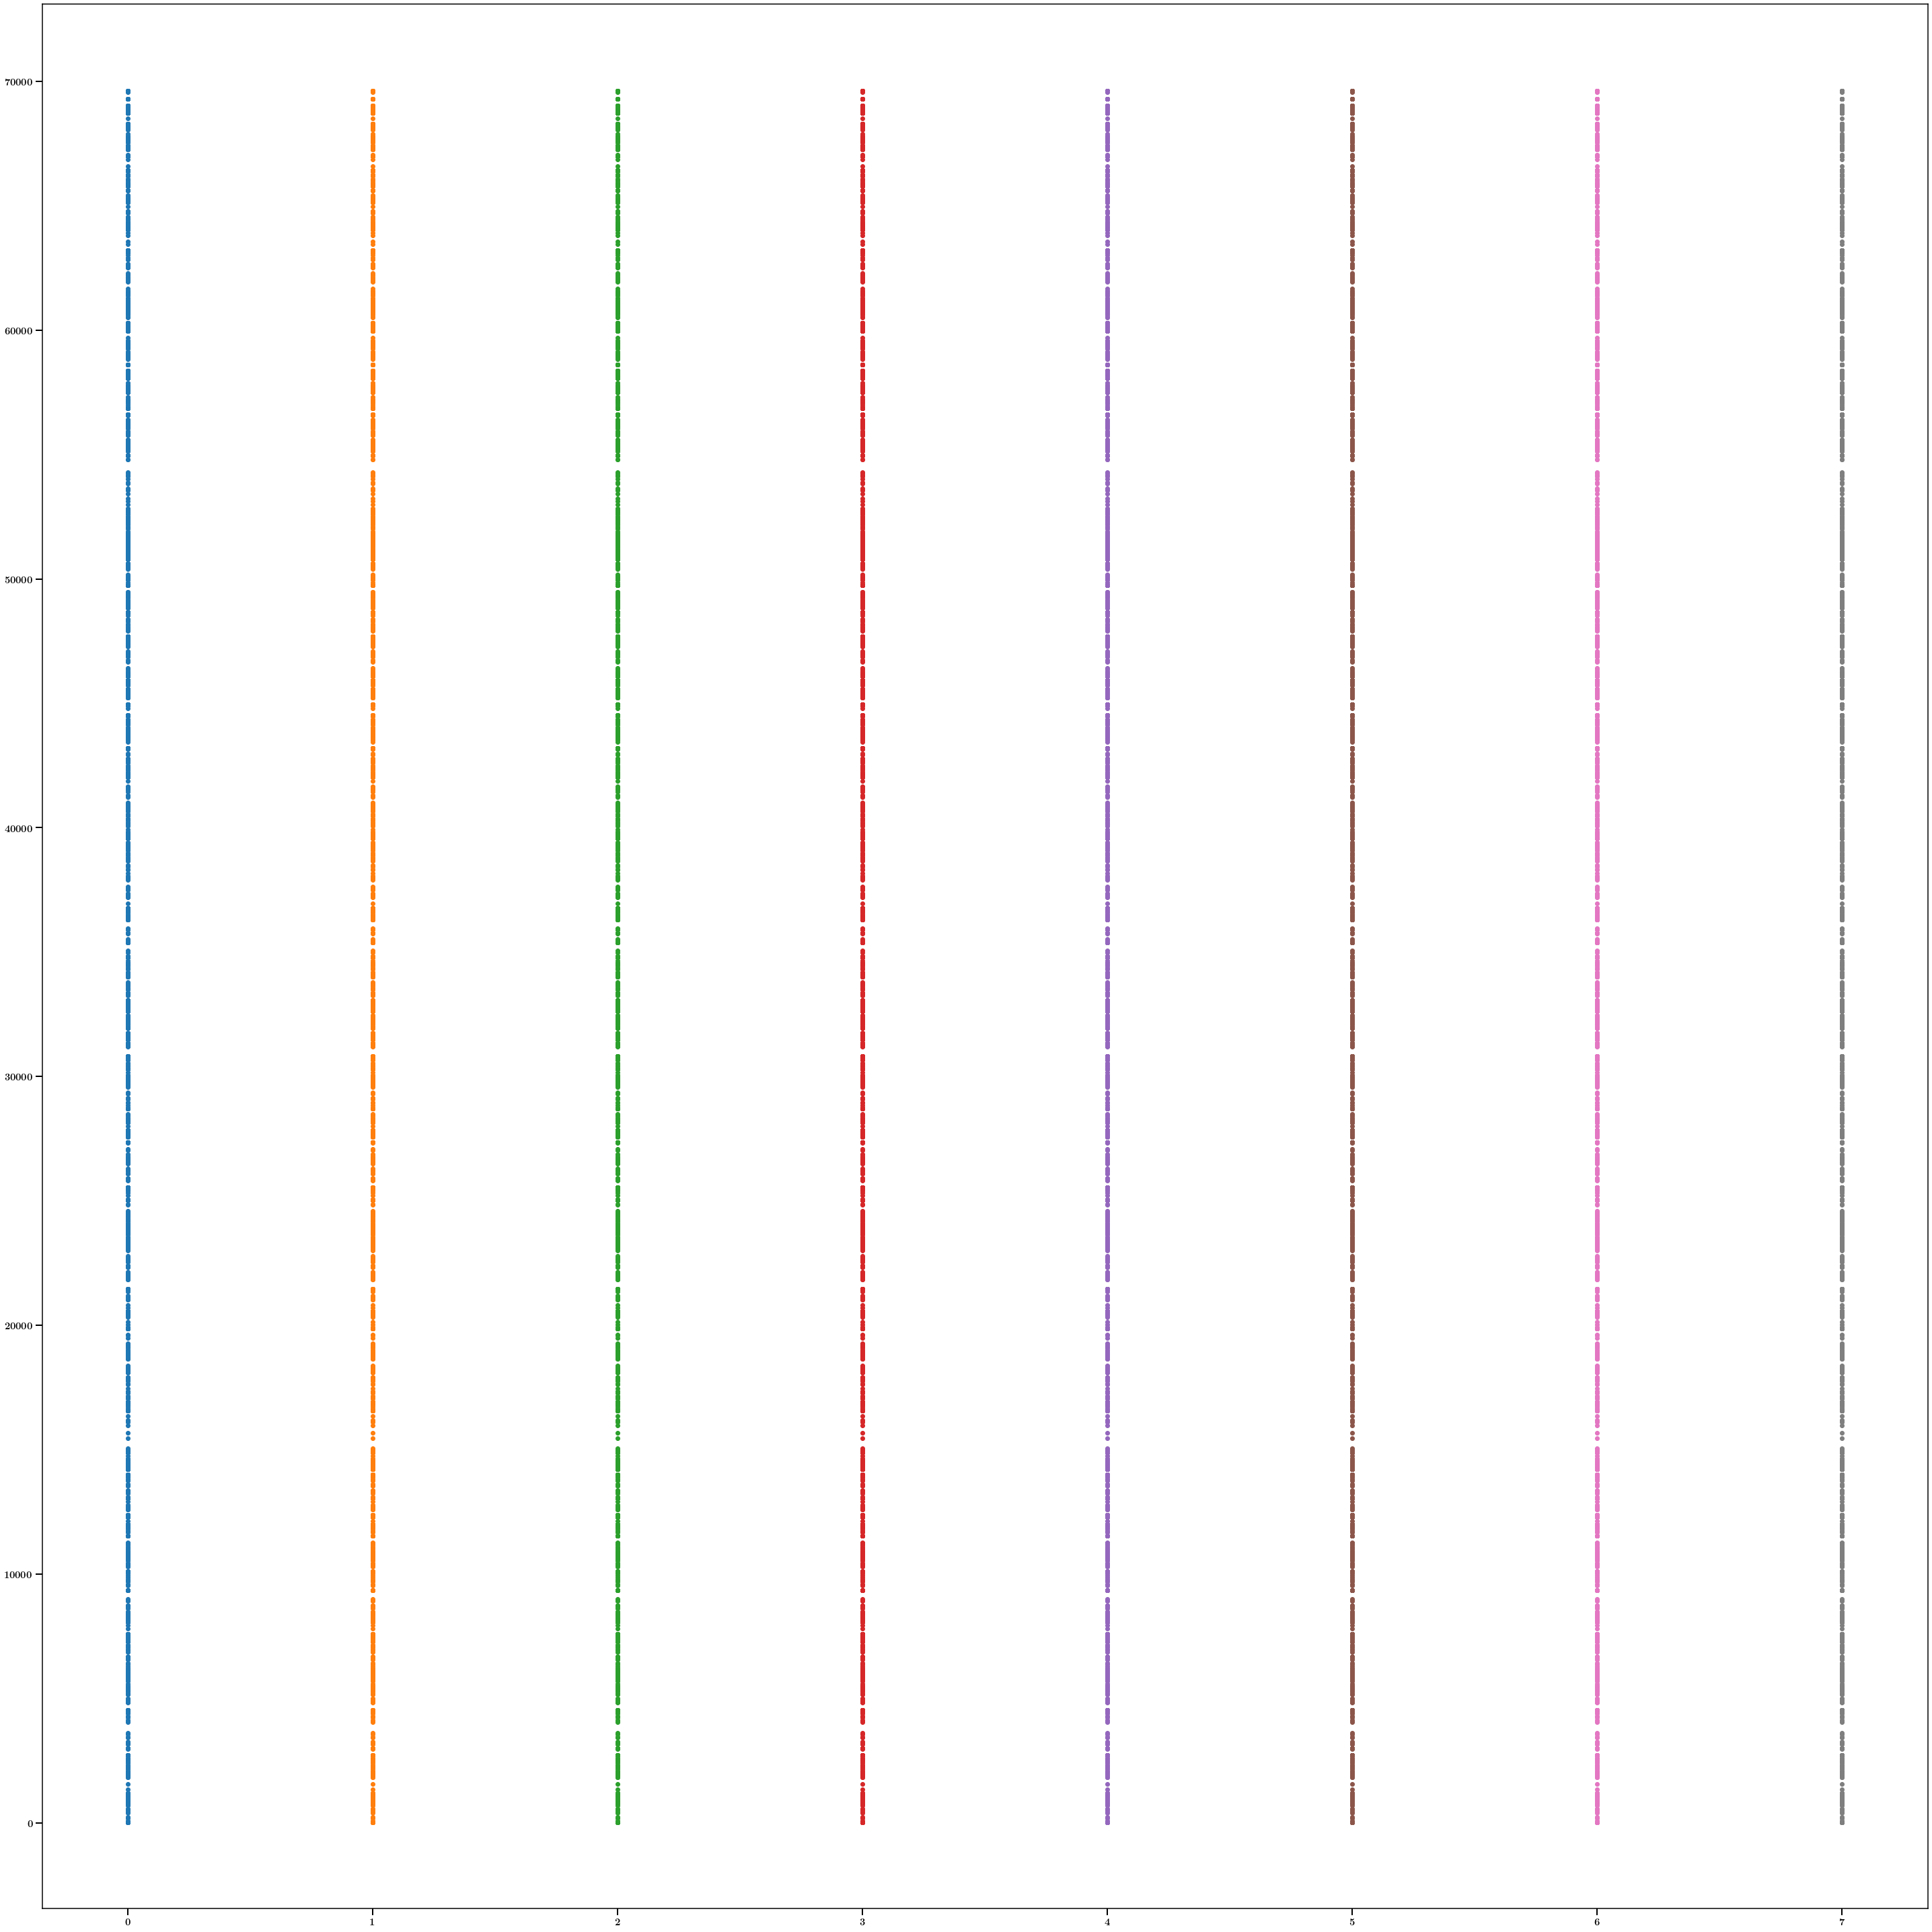

In [97]:
data_miss["date"] = pd.to_datetime(data_miss["measured_at"]).view(int)/ 10**9 / 60. # in minutes
min_min = np.min(data_miss["date"])
data_miss["date"] = data_miss["date"] - min_min
data_miss = data_miss.sort_values(by='date')
labels = ['wind_speed', 'power', 'rotor_speed', 'generator_speed', 'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'blade_angle_avg']
fig = plt.figure(figsize=(40, 40))
for lidx, l in enumerate(labels):
    col = data_miss['wind_speed'][data_miss['turbine_id'] == 14]
    mis_idxs = np.where(np.isnan(np.asarray(col)))[0]
    plt.scatter(np.full((mis_idxs.size,), lidx), mis_idxs)

In [94]:
data_miss.iloc[315]

index                                    399955
turbine_id                                   22
measured_at           2019-01-01 05:50:00+00:00
wind_speed                             0.330769
power                                  0.054606
nacelle_direction                          55.9
wind_direction                             57.2
rotor_speed                            0.558333
generator_speed                        0.502933
temp_environment                            8.0
temp_hydraulic_oil                         42.0
temp_gear_bearing                          59.0
cosphi                                      1.0
blade_angle_avg                            -2.6
hydraulic_pressure                        246.9
park_id                                       2
error_category                         NO_ERROR
date                                      350.0
Name: 399955, dtype: object

# 1st Try with kNN

Implement kNN for each individual turbine. Distance is given by time and target by the 8 possible missing values

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import Normalizer

In [6]:
# convert to minute time stamp
data_full["date"] = pd.to_datetime(data_full["measured_at"]).view(int)/ 10**9 / 60. # in minutes
min_min = np.min(data_full["date"])
data_full["date"] = data_full["date"] - min_min

In [50]:
for ns in range(2, 10):
    # optimize n neighbors
    neigh = KNeighborsRegressor(n_neighbors=ns)

    ids = np.where(data_full['turbine_id'] == 11)[0]
    data_train = data_full.loc[ids]
    X = np.asarray(data_train['date']).reshape(-1, 1)
    Y = np.asarray(data_train[['wind_speed', 'power', 'rotor_speed', 'generator_speed', 'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'blade_angle_avg']])
    transformer = Normalizer().fit(Y)
    Y = transformer.transform(Y)
    
    neigh.fit(X, Y)
    err = np.mean(np.power((Y - neigh.predict(X)), 2.), axis=0)
    var = np.var(Y, axis=0)
    print(f"{ns} , {err}")

2 , [2.44248476e-07 3.75642563e-07 7.43863832e-07 5.00334809e-07
 2.60174448e-05 6.50649532e-05 9.57722587e-05 1.23408538e-03]
3 , [2.38750264e-07 3.64907381e-07 6.72200013e-07 4.51596796e-07
 2.39690880e-05 5.51127407e-05 7.92074383e-05 1.08566449e-03]
4 , [3.80490462e-07 5.87753159e-07 1.13989706e-06 7.67561938e-07
 3.90332827e-05 9.74884979e-05 1.42625216e-04 1.86177381e-03]
5 , [4.31408151e-07 6.68296819e-07 1.31868318e-06 8.88436814e-07
 4.30437648e-05 1.09765408e-04 1.62909996e-04 2.16472798e-03]
6 , [5.34585286e-07 8.30965059e-07 1.66582856e-06 1.12353106e-06
 5.51400544e-05 1.45079965e-04 2.16378912e-04 2.75773364e-03]
7 , [5.86369215e-07 9.14217854e-07 1.83328619e-06 1.23756300e-06
 6.06625497e-05 1.61796889e-04 2.39950291e-04 3.04910984e-03]
8 , [6.68366579e-07 1.04194538e-06 2.11596663e-06 1.42870966e-06
 7.09330407e-05 1.91773667e-04 2.86434038e-04 3.53740073e-03]
9 , [7.18429142e-07 1.12236130e-06 2.27303994e-06 1.53543150e-06
 7.66374001e-05 2.09926343e-04 3.10910661e-04 

In [75]:
# optimize n neighbors
for ns in range(1, 10):
    ids = np.where(data_full['turbine_id'] == 11)[0]
    data_train = data_full.loc[ids]
    X = np.asarray(data_train['date']).reshape(-1, 1)
    Y = np.asarray(data_train[['wind_speed', 'power', 'rotor_speed', 'generator_speed', 'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'blade_angle_avg']])
    transformer = Normalizer().fit(Y)
    Y = transformer.transform(Y)

    prediction = np.zeros((1000, 8))
    for ix in frogress.bar(range(X.shape[0])):
        neigh = KNeighborsRegressor(n_neighbors=ns)
        if ix == 1000:
            break
        neigh.fit(np.delete(X, ix, axis=0), np.delete(Y, ix, axis=0))
        prediction[ix] = neigh.predict(X[ix].reshape(-1, 1))
    err = np.mean(np.power((Y[:1000] - prediction), 2.), axis=0)
    print(f"{ns} , {err}")

  1.4% | [..........] | Progress: 1000 / 69613 | Time: 16.5s | ETA: 18min52s1 , [6.58725058e-07 1.52129964e-06 1.00326971e-06 6.99030355e-07
 4.31467981e-05 1.05192983e-04 7.26728583e-05 8.56101247e-04]
  1.4% | [..........] | Progress: 1000 / 69613 | Time: 17.4s | ETA: 19min51s2 , [3.18561317e-07 7.37957731e-07 5.28149277e-07 3.62940444e-07
 2.05067502e-05 3.73645746e-05 3.45898930e-05 5.64333233e-04]
  1.4% | [..........] | Progress: 1001 / 69613 | Time: 17.3s | ETA: 19min45s3 , [4.46585321e-07 1.06571143e-06 8.50014935e-07 5.87212553e-07
 2.62682744e-05 6.94988000e-05 6.04782579e-05 9.37067245e-04]
  1.4% | [..........] | Progress: 1000 / 69613 | Time: 18.3s | ETA: 20min59s4 , [4.53424905e-07 1.06053064e-06 8.78412794e-07 6.06363827e-07
 2.56432257e-05 6.59557443e-05 6.22877945e-05 9.87981373e-04]
  1.4% | [..........] | Progress: 1001 / 69613 | Time: 19.0s | ETA: 21min40s5 , [5.52418858e-07 1.32741981e-06 1.06477240e-06 7.37638333e-07
 3.08664759e-05 9.53971750e-05 8.20179508e-05 1

KeyboardInterrupt: 

kNN is pretty good as a first guess except for blade_angle_avg and maybe temp_gear_bearing

n_neighbours=2 performs best

weights=distance is better than uniform




so far only using data from previous values.


How to use correlation with other values? / Other turbines in the windpark?

For environmental variables: temp_environment and wind_speed

## 2. Try use data from all turbines in the windpark to build kNN

In [28]:
for ns in range(2, 10):
    # optimize n neighbors
    neigh = KNeighborsRegressor(n_neighbors=ns)

    ids = np.where(data_full['park_id'] == 1)[0]
    data_train = data_full.loc[ids]
    X = np.asarray(data_train['date']).reshape(-1, 1)
    Y = np.asarray(data_train[['wind_speed', 'power', 'rotor_speed', 'generator_speed', 'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'blade_angle_avg']])
    transformer = Normalizer().fit(Y)
    Y = transformer.transform(Y)
    neigh.fit(X, Y)

    # validation
    ids = np.where(data_full['turbine_id'] == 11)[0]
    data_test = data_full.loc[ids]
    X = np.asarray(data_test['date']).reshape(-1, 1)
    Y = np.asarray(data_test[['wind_speed', 'power', 'rotor_speed', 'generator_speed', 'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'blade_angle_avg']])
    Y = transformer.transform(Y)
    err = np.mean(np.power((Y - neigh.predict(X)), 2.), axis=0)
    var = np.var(Y, axis=0)
    # print(f"{ns} , {np.sqrt(err / var) * 100}")
    print(f"{ns} , {err}")

2 , [32.01594472 26.32283827 36.41641729 36.85919201 16.42828787 82.11788942
 57.00932915 50.27242905]
3 , [29.42086844 24.0974696  34.0181638  34.42204791 15.4761265  75.41546943
 52.34982223 46.97207576]
4 , [28.3905816  23.27870416 33.32424714 33.70949189 15.04033631 68.10563306
 49.04455125 45.69691895]
5 , [28.3905816  23.27870416 33.32424714 33.70949189 15.04033631 68.10563306
 49.04455125 45.69691895]
6 , [28.3905816  23.27870416 33.32424714 33.70949189 15.04033631 68.10563306
 49.04455125 45.69691895]
7 , [28.3905816  23.27870416 33.32424714 33.70949189 15.04033631 68.10563306
 49.04455125 45.69691895]
8 , [28.3905816  23.27870416 33.32424714 33.70949189 15.04033631 68.10563306
 49.04455125 45.69691895]
9 , [28.3905816  23.27870416 33.32424714 33.70949189 15.04033631 68.10563306
 49.04455125 45.69691895]


Fail, that is much worse than before

# Check spatial correlation of wind speed

In [18]:
data_sort = data_full.sort_values(by='date')
idx11 = np.where(data_full['turbine_id'] == 11)[0]
idx12 = np.where(data_full['turbine_id'] == 13)[0]
missing_in_12 = np.setdiff1d(np.asarray(data_sort['date'][idx11]), np.asarray(data_sort['date'][idx12]))
missing_in_11 = np.setdiff1d(np.asarray(data_sort['date'][idx12]), np.asarray(data_sort['date'][idx11]))
missing = np.unique(np.append(missing_in_11, missing_in_12))
idx11 = np.where(np.logical_and(data_full['turbine_id'] == 11, np.logical_not(np.isin(data_full['date'], missing))))[0]
idx12 = np.where(np.logical_and(data_full['turbine_id'] == 13, np.logical_not(np.isin(data_full['date'], missing))))[0]
print(len(idx11), len(idx12))
wind11 = data_sort['wind_speed'][idx11]
wind12 = data_sort['wind_speed'][idx12]

69588 69588


In [19]:
random_indices = np.random.choice(wind11.shape[0], size=10000, replace=False)
comb = np.hstack((np.asarray(wind11).reshape(-1, 1), np.asarray(wind12).reshape(-1, 1)))

coeff = np.corrcoef(comb[random_indices], rowvar=False)

In [20]:
coeff

array([[1.        , 0.95367573],
       [0.95367573, 1.        ]])

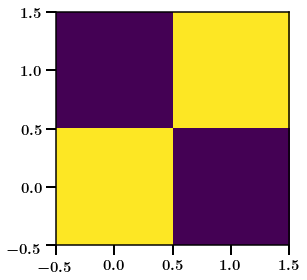

In [13]:
import matplotlib.pyplot as plt
plt.imshow(coeff)

Wind speed is strongly correlated between different turbines in 1 parc -> spatial correlation should help

# 4) Predict from other turbines in the parc

very simple, for environement variables simply use average of values in the parc at the same time 

In [45]:
# training data
ids = np.where(np.logical_and(data_full['park_id'] == 1, data_full['turbine_id'] != 11))[0]
data_train = data_full.loc[ids]
X = np.asarray(data_train['date']).reshape(-1, 1)
Y = np.asarray(data_train[['wind_speed', 'power', 'rotor_speed', 'generator_speed', 'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'blade_angle_avg']])
transformer = Normalizer().fit(Y)
Y = transformer.transform(Y)


In [46]:

ids = np.where(data_full['turbine_id'] == 11)[0]
data_train = data_full.loc[ids]
X_test = np.asarray(data_train['date']).reshape(-1, 1)
Y_test = np.asarray(data_train[['wind_speed', 'power', 'rotor_speed', 'generator_speed', 'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'blade_angle_avg']])
Y_test = transformer.transform(Y_test)

In [37]:
prediction = np.zeros((X_test.shape[0],8))
import frogress
for ix, x in frogress.bar(enumerate(X_test)):
    close_turbines = np.isclose(X, x)
    pred = np.mean(Y[close_turbines.ravel(), :], axis=0)
    prediction[ix] = pred

[##########] | Progress: 69613 | Time: 2min51s | ETA: --

In [47]:
err = np.mean(np.power((Y_test - prediction), 2.), axis=0)
var = np.var(Y, axis=0)
print(f"{err}")

[1.91314415e-06 1.89377156e-06 6.96640725e-06 4.83596561e-06
 5.64049030e-04 3.90471792e-03 4.60406325e-03 1.47296167e-02]


Predicting from kNN is better.

Unfortunately, kNN will not work well since usually long chains are missing.

Use kNN for single missing values though.

# 5) xgboost

In [18]:
attributes = ['wind_speed', 'power', 'rotor_speed', 'generator_speed', 'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'blade_angle_avg']

In [19]:
ids = np.where(data_full['turbine_id'] == 11)[0]
data_train = data_full.loc[ids]
# X = np.asarray(data_train['date']).reshape(-1, 1)
Y = np.asarray(data_train[['wind_speed', 'power', 'rotor_speed', 'generator_speed', 'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'blade_angle_avg']])
transformer = Normalizer().fit(Y)
Y = transformer.transform(Y)

In [22]:
for ia, attribute in enumerate(attributes):
    X_ = np.delete(Y, ia, axis=1)
    Y_ = Y[:, ia]
    X_train, X_test, y_train, y_test = train_test_split(X_, Y_, test_size=0.2, random_state=42)

    xgb=XGBRegressor()
    #params={"n_estimators":[4,8,16,32,64,128,256,512], "max_depth":[4,6,8,10,20,30,50],"learning_rate":[0.2,0.5,0.9],
    #       "reg_lambda":[0,0.1,0.01]}
    params={"n_estimators":[100], "max_depth":[6],"learning_rate":[0.5],
        "reg_lambda":[0.1]}

    xgb_cv=GridSearchCV(xgb,params, cv=10)

    xgb_cv.fit(X_train, y_train)
    score = np.mean((y_test - xgb_cv.predict(X_test))**2)
    print(f"{attribute}: {score}")

wind_speed: 9.946953720885588e-08
power: 2.892774364992313e-07
rotor_speed: 1.3303000840545725e-08
generator_speed: 1.6132438677534424e-08
temp_environment: 0.000310088585428031
temp_hydraulic_oil: 1.3367431767655604e-05
temp_gear_bearing: 1.0728171610267973e-05
blade_angle_avg: 0.00012131621800119139


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

In [14]:
xgb=XGBRegressor()
#params={"n_estimators":[4,8,16,32,64,128,256,512], "max_depth":[4,6,8,10,20,30,50],"learning_rate":[0.2,0.5,0.9],
#       "reg_lambda":[0,0.1,0.01]}
params={"n_estimators":[100], "max_depth":[6],"learning_rate":[0.5],
       "reg_lambda":[0.1]}

xgb_cv=GridSearchCV(xgb,params, cv=10)

xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,

In [17]:
np.mean((y_test - xgb_cv.predict(X_test))**2)

1.0971796943675474e-07

6) xgboost seriously

In [254]:
import copy
import frogress
import datetime as dt

class SIB:
    def __init__(self, missing_attributes=['wind_speed', 'power', 'rotor_speed', 'generator_speed', 'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'blade_angle_avg'], iterations=3, debug=False):
        self.missing_attributes = np.asarray(missing_attributes)
        self.debug = debug
        self.iterations = iterations

    def train_xgb(self, df):
        # for each parc get the average of each attribute at each time

        # get all park ids
        self.park_ids = np.unique(df['park_id'])

        # preprocessing
        self.df_train = copy.deepcopy(df)
        self.df_train["measured_at"]=pd.to_datetime(self.df_train.measured_at)
        self.df_train["week"]=self.df_train.measured_at.dt.isocalendar().week.astype(int)
        self.df_train["month"]=self.df_train.measured_at.dt.month
        self.df_train["hourofday"]=self.df_train.measured_at.dt.hour
        self.df_train["isnight"]=(self.df_train.hourofday >= 18) | (self.df_train.hourofday <=5)
        self.df_train["isnoon"]=(self.df_train.hourofday >= 7) & (self.df_train.hourofday<=14)
        self.df_train["Error"]=self.df_train.error_category != "NO_ERROR"
        self.df_train["speed"]=(self.df_train.rotor_speed+self.df_train.generator_speed)
        self.df_train["direction"]=(self.df_train.nacelle_direction+self.df_train.wind_direction)


        if self.debug:
            self.df_train = self.df_train.iloc[:100]

    
        # build xgboost for each attribute
        self.xgbs = {}
        for at in self.missing_attributes:
            print(f"Building xgb for attribute {at}")
            xgb=XGBRegressor()
            #params={"n_estimators":[4,8,16,32,64,128,256,512], "max_depth":[4,6,8,10,20,30,50],"learning_rate":[0.2,0.5,0.9],
            #       "reg_lambda":[0,0.1,0.01]}

            # insert best values here!
            params={"n_estimators":[100], "max_depth":[6],"learning_rate":[0.5],
                "reg_lambda":[0.1]}

            xgb_cv=GridSearchCV(xgb, params, cv=10)
            y = self.df_train[at]
            x = self.df_train.drop(columns=[at, 'measured_at', 'error_category', "index", 'nacelle_direction', 'wind_direction', 'rotor_speed', 'generator_speed'])
            xgb_cv.fit(x, y)

            self.xgbs[at] = xgb_cv

        del self.df_train

    def train_spartial(self, df_miss):

        df_miss_ = copy.deepcopy(df_miss)
        times = pd.to_datetime(df_miss_["measured_at"]).view(int)/ 10**9 / 60. # in minutes
        self.time_zero_point = np.min(times)
        self.times = times - self.time_zero_point
        df_miss_['date'] = self.times
        self.times = np.unique(np.asarray(self.times, dtype=int))

        # calculate the averages of the attributes for each park and time    
        averages = {}
        for park_id in self.park_ids:
            print(f"Building partial interpolator for park {park_id}")
            idx = np.where(df_miss_["park_id"] == park_id)[0]
            df_park = df_miss_.iloc[idx]
            averages[park_id] = np.zeros((len(self.times), len(self.missing_attributes)))
            for idt, time in frogress.bar(enumerate(self.times)):
                idx_time = np.where(df_park['date'] == time)[0]
                if len(idx_time) == 0:
                    averages[park_id][idt] = np.full((len(self.missing_attributes,)), np.nan)
                else:
                    averages[park_id][idt] = np.nanmean(df_park[self.missing_attributes].iloc[idx_time], axis=0)
                if self.debug:
                    if idt > 100:
                        break
        self.averages = averages 
        del df_miss_


    def predict(self, X):
        x = copy.deepcopy(X)
        x = x.to_frame().T
        x = x.astype({'turbine_id' : int, 'power' : float, 'temp_environment' : float, 'temp_hydraulic_oil' : float, 'temp_gear_bearing': float, 'cosphi': float, 'blade_angle_avg': float, 'hydraulic_pressure': float, 'park_id': int, 'rotor_speed': float, 'generator_speed' : float, 'nacelle_direction':float, 'wind_direction': float})

        # get missing attributes
        check_nans = x.isna()
        check_nans = np.asarray(check_nans).reshape(-1)
        missing_attributes = list(data_miss.keys()[check_nans])
        time = pd.to_datetime(x["measured_at"]).view(int) / 10**9 / 60. # in minutes
        time = time - self.time_zero_point
        park = x['park_id']

        avg = self.averages[int(park)][np.where(np.asarray(self.times) == int(time))[0][0], :]
        # replace with initial guess as averages of windpark
        for at in missing_attributes:
            x[at] = avg[np.where(self.missing_attributes == at)[0][0]]

        # preprocessing
        temp=pd.to_datetime(x.measured_at)
        x["week"]=temp.dt.isocalendar().week.astype(int)
        x["month"]=temp.dt.month
        x["hourofday"]=temp.dt.hour
        x["isnight"]=(x.hourofday >= 18) | (x.hourofday <=5)
        x["isnoon"]=(x.hourofday >= 7) & (x.hourofday<=14)
        x["Error"]=x.error_category != "NO_ERROR"
        x["speed"]=(x.rotor_speed+x.generator_speed)
        x["direction"]=(x.nacelle_direction+x.wind_direction)

        # run xgbs
        for iter in range(self.iterations):
            for at in missing_attributes:
                x[at]= self.xgbs[at].predict(x.drop(columns=[at, 'measured_at', 'error_category', "index", 'nacelle_direction', 'wind_direction', 'rotor_speed', 'generator_speed']))
        x = x.drop(columns=["week", "month", 'hourofday', 'isnight', 'isnoon', 'Error', 'speed', 'direction'])
        return x


In [255]:
sib = SIB(debug=True)
sib.train_xgb(data_full)
sib.train_spartial(data_miss)
sib.predict(data_miss.iloc[315])

Building xgb for attribute wind_speed
Building xgb for attribute power
Building xgb for attribute rotor_speed
Building xgb for attribute generator_speed
Building xgb for attribute temp_environment
Building xgb for attribute temp_hydraulic_oil
Building xgb for attribute temp_gear_bearing
Building xgb for attribute blade_angle_avg
Building spartial interpolator for park 1
[..#.......] | Progress: 88 | Time: 0.1s | ETA: --Building spartial interpolator for park 2
[....#.....] | Progress: 101 | Time: 3.6s | ETA: --

,index,turbine_id,measured_at,wind_speed,power,nacelle_direction,wind_direction,rotor_speed,generator_speed,temp_environment,temp_hydraulic_oil,temp_gear_bearing,cosphi,blade_angle_avg,hydraulic_pressure,park_id,error_category
315,315,11,2020-01-03 04:30:00+00:00,0.549477,0.40335,205.2,203.0,0.959732,0.802083,4.0,19.0,43.0,0.98,-2.1,189.5,1,NO_ERROR
